In [1]:
dataset_ver = 3

In [2]:
# !pip install torchinfo

In [18]:
# from google.colab import drive
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import io
import contextlib
import copy
import shutil
import re
from torch.utils.data import Subset
import sys
import time

In [4]:
# ================================
# 1. Dataset
# ================================
class FlagWindDataset(Dataset):
    def __init__(self, data_dir, target_dir, max_frames=280):
        self.samples = []
        self.flag_mean = None
        self.flag_std = None
        self.disp_mean = None
        self.disp_std = None
        self.wind_mean = None
        self.wind_std = None
        
        for iteration in range(1, 101):
            for frame in range(1, max_frames + 1):
                flag_file = os.path.join(data_dir, f"flag_{iteration:03d}_{frame:03d}.npy")
                wind_file = os.path.join(data_dir, f"wind_{iteration:03d}_{frame:03d}.npy")
                disp_file = os.path.join(target_dir, f"displacement_{iteration:03d}_{frame:03d}.npy")
                if os.path.exists(flag_file) and os.path.exists(wind_file) and os.path.exists(disp_file):
                    self.samples.append((flag_file, wind_file, disp_file))

    def set_stats(self, flag_mean, flag_std, disp_mean, disp_std, wind_mean, wind_std):
        # Helper function to set stats after calculating them from train_set
        self.flag_mean = flag_mean
        self.flag_std = flag_std
        self.disp_mean = disp_mean
        self.disp_std = disp_std
        self.wind_mean = wind_mean
        self.wind_std = wind_std

    def __len__(self):
        return len(self.samples)

    def load_raw(self, idx):
        # Helper to load raw data for stat calculation
        flag_file, wind_file, disp_file = self.samples[idx]
        flag = np.load(flag_file).astype(np.float32)
        wind = np.load(wind_file).astype(np.float32)
        disp = np.load(disp_file).astype(np.float32)
        return flag, wind, disp

    def __getitem__(self, idx):
        flag, wind, disp = self.load_raw(idx)

        # Normalize if stats are available
        if self.flag_mean is not None:
            flag = (flag - self.flag_mean) / (self.flag_std + 1e-8) # Add epsilon to avoid divide by zero
            disp = (disp - self.disp_mean) / (self.disp_std + 1e-8)
            wind = (wind - self.wind_mean) / (self.wind_std + 1e-8)

        return torch.from_numpy(flag), torch.from_numpy(wind), torch.from_numpy(disp)

In [5]:
def SplitDataset(dataset, train_ratio=0.8):
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    return train_dataset, test_dataset

In [6]:
def SplitDatasetByIteration(dataset, train_ratio=0.8):
    """
    Split dataset deterministically by iteration index.
    First train_ratio * total_iters iterations go to train, rest to test.
    """
    # detect total iterations from dataset
    iters = sorted(set(int(os.path.basename(f).split("_")[1]) for f,_,_ in dataset.samples))
    total_iters = max(iters)

    train_iters = int(train_ratio * total_iters)

    train_samples, test_samples = [], []
    for (flag_file, wind_file, disp_file) in dataset.samples:
        iteration = int(os.path.basename(flag_file).split("_")[1])
        if iteration <= train_iters:
            train_samples.append((flag_file, wind_file, disp_file))
        else:
            test_samples.append((flag_file, wind_file, disp_file))

    # Create shallow dataset copies with filtered samples
    train_dataset = FlagWindDataset.__new__(FlagWindDataset)
    test_dataset = FlagWindDataset.__new__(FlagWindDataset)

    train_dataset.samples = train_samples
    test_dataset.samples = test_samples

    return train_dataset, test_dataset

In [7]:
# ================================
# 2. Model
# ================================
class FlagWindNet(nn.Module):
    def __init__(self, flag_dim=3, wind_dim=3, hidden_dim=128):
        super().__init__()
        # process each flag vertex independently
        self.flag_mlp = nn.Sequential(
            nn.Linear(flag_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        # process wind info
        self.wind_mlp = nn.Sequential(
            nn.Linear(8 * wind_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        # fuse + predict displacement
        self.out_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3)  # predict dx, dy, dz per vertex
        )

    def forward(self, flag, wind):
        """
        flag: (B, 1024, 3)
        wind: (B, 8, 3)
        """
        B, N, _ = flag.shape
        flag_feat = self.flag_mlp(flag)          # (B, N, hidden_dim)

        wind_feat = wind.view(B, -1)             # (B, 24)
        wind_feat = self.wind_mlp(wind_feat)     # (B, hidden_dim)
        wind_feat = wind_feat.unsqueeze(1).expand(-1, N, -1)  # (B, N, hidden_dim)

        fused = torch.cat([flag_feat, wind_feat], dim=-1)  # (B, N, 2*hidden_dim)
        out = self.out_mlp(fused)               # (B, N, 3)
        return out

In [8]:
model_description = """
A Single-Timestep Spatial Fusion Network for Flag Displacement Prediction.

This network processes the high-dimensional flag state and low-dimensional wind context
at a single moment in time (a single frame).

1.  **Vertex Processing:** The `flag_mlp` processes the 3D coordinates (x, y, z) of each 
    of the **1024 flag vertices (N)** independently, mapping them into a shared latent space 
    of size `hidden_dim`.
    
2.  **Global Wind Context:** The `wind_mlp` flattens the 8-point wind vector (8*3=24 features) 
    and transforms it into a single, global `hidden_dim`-sized context vector.
    
3.  **Spatial Fusion:** The global wind context is **broadcast** and concatenated with the 
    latent feature of every single flag vertex (N=1024). This fuses the global force (wind) 
    with the local state (vertex position).
    
4.  **Prediction:** The `out_mlp` takes the fused vector (2 * hidden_dim) and predicts 
    the 3D displacement (dx, dy, dz) for that specific vertex.
    
The overall output is the displacement for all 1024 flag vertices: (Batch Size, 1024, 3).
"""

In [9]:
# ================================
# 3. Training loop with progress %
# ================================
def train_model(train_set, val_set, batch_size=32, epochs=10, lr=1e-3, device="cuda"):

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    model = FlagWindNet().to(device)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # --- ADDED: Lists to store history ---
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for flag, wind, disp in train_loader:
            flag, wind, disp = flag.to(device), wind.to(device), disp.to(device)
            optimizer.zero_grad()
            pred_disp = model(flag, wind)
            loss = criterion(pred_disp, disp)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for flag, wind, disp in val_loader:
                flag, wind, disp = flag.to(device), wind.to(device), disp.to(device)
                pred_disp = model(flag, wind)
                loss = criterion(pred_disp, disp)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

        # --- ADDED: Append losses to history ---
        train_loss_history.append(avg_train_loss)
        val_loss_history.append(avg_val_loss)

    # --- CHANGED: Return the history lists ---
    return model, train_loss_history, val_loss_history

In [10]:
def flag_vis(flag, pred, margin=0.1, equal_axes=True):
    pred_flag = flag.numpy() + pred.numpy()

    fig = plt.figure(figsize=(12, 6))

    # Compute min/max for each axis
    lims = np.array([
        [min(flag[:,0].min(), pred_flag[:,0].min()), max(flag[:,0].max(), pred_flag[:,0].max())],
        [min(flag[:,1].min(), pred_flag[:,1].min()), max(flag[:,1].max(), pred_flag[:,1].max())],
        [min(flag[:,2].min(), pred_flag[:,2].min()), max(flag[:,2].max(), pred_flag[:,2].max())],
    ])

    # Add margin (10% by default)
    ranges = lims[:,1] - lims[:,0]
    lims[:,0] -= margin * ranges
    lims[:,1] += margin * ranges

    # Optionally force equal aspect ratio (cube box)
    if equal_axes:
        max_range = ranges.max()
        centers = lims.mean(axis=1)
        lims[:,0] = centers - max_range/2 * (1 + margin)
        lims[:,1] = centers + max_range/2 * (1 + margin)

    # Original
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(flag[:,0], flag[:,1], flag[:,2], c='blue', s=8, alpha=0.7)
    ax1.set_title("Original Flag")
    ax1.set_xlim(lims[0]); ax1.set_ylim(lims[1]); ax1.set_zlim(lims[2])
    ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])
    ax1.grid(False)

    # Predicted
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(pred_flag[:,0], pred_flag[:,1], pred_flag[:,2], c='red', s=8, alpha=0.7)
    ax2.set_title("Predicted Flag")
    ax2.set_xlim(lims[0]); ax2.set_ylim(lims[1]); ax2.set_zlim(lims[2])
    ax2.set_xticks([]); ax2.set_yticks([]); ax2.set_zticks([])
    ax2.grid(False)

    # Match same view
    ax2.view_init(elev=ax1.elev, azim=ax1.azim)

    plt.tight_layout()
    plt.show()

In [11]:
ds = FlagWindDataset(data_dir="../datasets/3/BlenderOutputs_Sim", target_dir="../datasets/3/displacements")

In [12]:
# Define the iteration number to split on (e.g., 80 for train, 20 for test)
split_iteration = 80
train_indices = []
test_indices = []

# Create a regex to extract iteration number (e.g., "flag_081_...")
iter_regex = re.compile(r'.*_(\d{3})_\d{3}\.npy')

print("Splitting dataset by iteration...")

# Iterate through the original dataset's samples
for i, (flag_file, _, _) in enumerate(ds.samples):
    match = iter_regex.match(os.path.basename(flag_file))
    if match:
        iteration = int(match.group(1))

        # Assign index to train or test based on the iteration number
        if iteration <= split_iteration:
            train_indices.append(i)
        else:
            test_indices.append(i)

# Create the Subset objects using the manually created index lists
train_set = Subset(ds, train_indices)
test_set = Subset(ds, test_indices)

print(f"Split complete: {len(train_indices)} training samples, {len(test_indices)} test samples.")

Splitting dataset by iteration...
Split complete: 22400 training samples, 5600 test samples.


In [13]:
print("train set size:", len(train_set))
print("test set size:", len(test_set))

train set size: 22400
test set size: 5600


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Using device:", device)

# 1. Calculate Mean and Std from the TRAINING set
print("Calculating normalization stats from training set...")
flag_data = []
disp_data = []
wind_data = []

# Iterate through the train_set Subset to get the underlying dataset's samples
for idx in train_set.indices:
    flag, wind, disp = train_set.dataset.load_raw(idx) # We need a helper to load raw numpy data
    flag_data.append(flag)
    disp_data.append(disp)
    wind_data.append(wind)

# Stack all data and calculate stats
all_flags = np.stack(flag_data)
all_disps = np.stack(disp_data)
all_winds = np.stack(wind_data)

flag_mean = np.mean(all_flags, axis=(0, 1))
flag_std = np.std(all_flags, axis=(0, 1))
disp_mean = np.mean(all_disps, axis=(0, 1))
disp_std = np.std(all_disps, axis=(0, 1))
wind_mean = np.mean(all_winds, axis=(0, 1))
wind_std = np.std(all_winds, axis=(0, 1))

print("Stats calculated.")

print(f"FLAG MEAN: {flag_mean}")
print(f"FLAG STD:  {flag_std}")
print(f"DISP MEAN: {disp_mean}")
print(f"DISP STD:  {disp_std}")
print(f"WIND MEAN: {wind_mean}")
print(f"WIND STD:  {wind_std}")

# 2. Set stats for both train and test datasets
# This allows the __getitem__ to normalize on the fly
train_set.dataset.set_stats(flag_mean, flag_std, disp_mean, disp_std, wind_mean, wind_std)
test_set.dataset.set_stats(flag_mean, flag_std, disp_mean, disp_std, wind_mean, wind_std)

# 3. Create Tensors for denormalization (used in rollout)
# Move stats to the correct device for calculations
flag_mean_tensor = torch.tensor(flag_mean, dtype=torch.float32).to(device)
flag_std_tensor = torch.tensor(flag_std, dtype=torch.float32).to(device)
disp_mean_tensor = torch.tensor(disp_mean, dtype=torch.float32).to(device)
disp_std_tensor = torch.tensor(disp_std, dtype=torch.float32).to(device)
wind_mean_tensor = torch.tensor(wind_mean, dtype=torch.float32).to(device)
wind_std_tensor = torch.tensor(wind_std, dtype=torch.float32).to(device)

# 4. Create lookup dictionary for test_set to speed up rollout
print("Creating test set lookup...")
test_set_lookup = {}
for i, (flag_file, _, _) in enumerate(test_set.dataset.samples):
    # Check if this index is in the test_set subset
    if i in test_set.indices:
        parts = os.path.basename(flag_file).split('_')
        iteration = int(parts[1])
        frame = int(parts[2].split('.')[0])
        test_set_lookup[(iteration, frame)] = i
print("Lookup created.")

Using device: cuda
Calculating normalization stats from training set...
Stats calculated.
FLAG MEAN: [ 0.12910223 -0.03005729 -0.2029736 ]
FLAG STD:  [0.2569797  0.25402212 0.22280896]
DISP MEAN: [ 0.00028131 -0.00021091 -0.00083623]
DISP STD:  [0.01928047 0.02270363 0.01108402]
WIND MEAN: [15.901057  -2.9218872 -2.12621  ]
WIND STD:  [26.870325  20.354242   6.6090794]
Creating test set lookup...
Lookup created.


In [15]:
batch_size = 64
epochs = 1
lr = 1e-4

In [16]:
model, train_history, val_history = train_model(train_set, test_set, batch_size=64, epochs=1, lr=1e-4, device="cuda")

Epoch 1/1, Train Loss: 0.530607, Val Loss: 0.565100


In [29]:
def get_next_model_version(base_path="./models/SNN_"):
    """
    Automatically determines the next model version number (e.g., 001, 002, 003, ...)
    by scanning the existing directories.

    Args:
        base_path (str): The common prefix for your model directories (e.g., "./models/SNN_").
                         The function will look for directories matching this pattern
                         followed by a three-digit number.

    Returns:
        int: The next version number to use.
    """
    # 1. Ensure the base directory exists
    model_dir = os.path.dirname(base_path)
    if not os.path.exists(model_dir):
        print(f"Base model directory '{model_dir}' not found. Starting version at 1.")
        return 1

    max_version = 0
    
    # 2. Iterate through all items in the model directory
    for item in os.listdir(model_dir):
        # 3. Use a regular expression to find directories that match the pattern "SNN_XXX"
        # The pattern looks for the prefix followed by exactly three digits (\d{3}).
        match = re.match(r"^SNN_(\d{3})$", item)
        
        if match:
            # 4. Extract the version number (the captured group 1) and update max_version
            version = int(match.group(1))
            if version > max_version:
                max_version = version

    # The next version is one greater than the maximum found
    next_version = max_version + 1
    
    print(f"Found max version {max_version}. Next version will be {next_version}.")
    return next_version

# --- Example Usage ---

# 1. Get the next version
model_ver = get_next_model_version() # This scans for directories like ./models/SNN_001, etc.

Found max version 0. Next version will be 1.


Training history plot saved as training_history.png


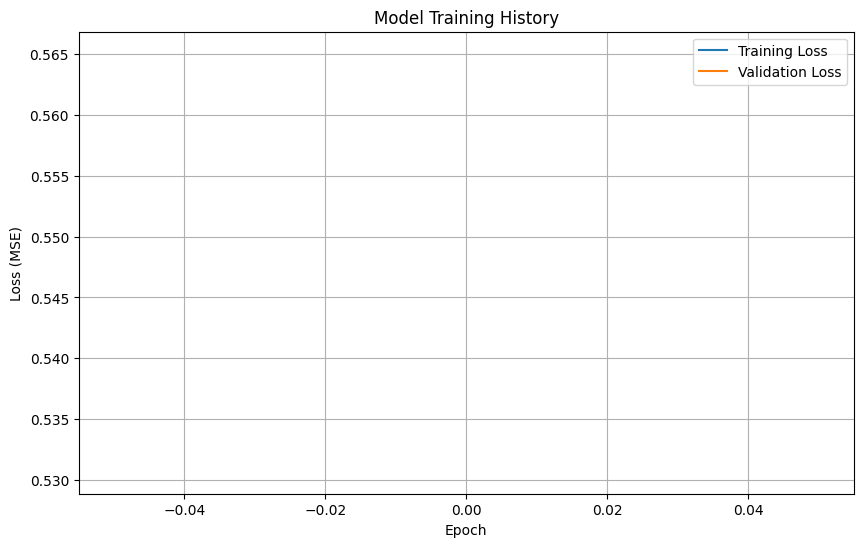

In [38]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_history, label='Training Loss')
plt.plot(val_history, label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plot_save_path = f"../models/SNN_{model_ver:03d}/"
# Save the plot as an image
plt.savefig(plot_save_path+"training_history.png")
print("Training history plot saved as training_history.png")

In [26]:
extra_details = """
Time: {time}

Model trained with:
- Batch Size: {batch_size}
- Epochs: {epochs}
- Learning Rate: {lr}
- Optimizer: Adam
- Loss Function: Mean Squared Error (MSE)
- Activation Function: ReLU
- Number of Hidden Layers: 2
- Hidden Layer Size: 128
- Dropout Rate: 0.1

Results:
- Final Training Loss: {final_train_loss:.6f}
- Final Validation Loss: {final_val_loss:.6f}
"""

In [30]:
model_save_path = f"../models/SNN_{model_ver:03d}/"

os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save model
torch.save(model.state_dict(), os.path.join(model_save_path, "flagwind_model_weights.pth"))
torch.save(model, os.path.join(model_save_path, "flagwind_model.pth"))

print("✅ Model saved to Google Drive")


# Save Model Description
description_path = os.path.join(model_save_path, "model_description.txt")
with open(description_path, "w") as f:
    f.write(model_description)
    f.write("\n")
    f.write(extra_details.format(
        batch_size=batch_size,
        epochs=epochs,
        lr=lr,
        final_train_loss=train_history[-1] if train_history else 0.0,
        final_val_loss=val_history[-1] if val_history else 0.0,
        time=time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    ))

✅ Model saved to Google Drive


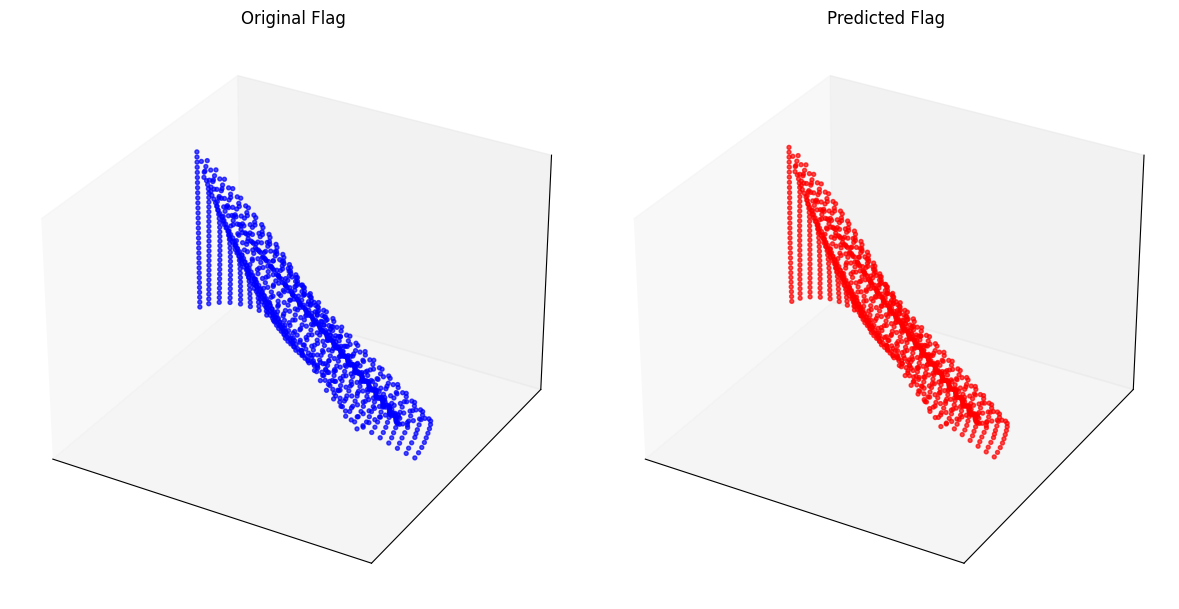

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = FlagWindNet().to(device)   # <<< move model to GPU

# pick a random index from the test set
idx = random.randint(0, len(test_set)-1)
flag, wind, disp = test_set[idx]

# add batch dimension for model
flag_b = flag.unsqueeze(0).to('cuda')
wind_b = wind.unsqueeze(0).to('cuda')

# model prediction
model.eval()
with torch.no_grad():
    pred = model(flag_b, wind_b).cpu().squeeze(0)  # shape (1024,3)

flag_vis(flag, pred)

In [32]:
def rollout_sequence(model, dataset, test_set_lookup,
                     flag_mean, flag_std, disp_mean, disp_std,
                     iteration=1, max_frames=280, device="cuda"):
    """
    Autoregressively predict flag positions for a given iteration.
    Uses normalization/denormalization.
    """
    model.eval()
    preds, gts, diss = [], [], []

    # Get the base dataset
    base_dataset = dataset.dataset

    # 1. Collect dataset indices for this iteration (FAST lookup)
    frames = []
    for frame in range(1, max_frames + 1):
        idx = test_set_lookup[(iteration, frame)]
        frames.append(idx)

    # 2. Load first frame
    # This data is NORMALIZED by the __getitem__ method
    flag, wind, _ = base_dataset[frames[0]]
    flag = flag.to(device)

    # Denormalize to store the "real" starting position
    # --- THIS IS THE FIXED LINE ---
    flag_real_start = flag.cpu() * flag_std.cpu() + flag_mean.cpu()
    gts.append(flag_real_start.numpy())
    preds.append(flag_real_start.numpy())

    # 3. Autoregressive rollout
    for i in range(max_frames - 1):

        # Get current wind
        _, wind, _ = base_dataset[frames[i]]
        wind_b = wind.unsqueeze(0).to(device)

        # Predict NORMALIZED displacement from NORMALIZED flag
        with torch.no_grad():
            # flag is already normalized and on device
            pred_disp_normalized = model(flag.unsqueeze(0), wind_b).squeeze(0)

        # Denormalize the predicted displacement to REAL coordinates
        pred_disp_real = pred_disp_normalized * disp_std + disp_mean

        # Denormalize the current flag to REAL coordinates
        flag_real = flag * flag_std + flag_mean

        # Calculate predicted next flag in REAL coordinates
        pred_next_real = flag_real + pred_disp_real

        # Get ground truth next flag
        # This is NORMALIZED
        gt_next_normalized, _, _ = base_dataset[frames[i+1]]
        # Denormalize GT for comparison (This line was already correct)
        gt_next_real = gt_next_normalized.cpu() * flag_std.cpu() + flag_mean.cpu()

        # Store REAL coordinate predictions and GTs
        preds.append(pred_next_real.cpu().numpy())
        gts.append(gt_next_real.numpy())
        diss.append(pred_disp_real.cpu().numpy())

        # Re-normalize the predicted next flag to feed back into model
        flag = (pred_next_real - flag_mean) / (flag_std + 1e-8)
        # flag = flag.to(device) # Already on device from calculation

    # 4. Get displacement for the final frame
    # (This block was the logic bug, now fixed to get the final displacement)
    _, wind, _ = base_dataset[frames[max_frames - 1]]
    wind_b = wind.unsqueeze(0).to(device)
    with torch.no_grad():
        # 'flag' now holds the normalized state for the *last* frame
        pred_disp_normalized = model(flag.unsqueeze(0), wind_b).squeeze(0)
    pred_disp_real = pred_disp_normalized * disp_std + disp_mean
    diss.append(pred_disp_real.cpu().numpy())

    return np.array(preds), np.array(gts), np.array(diss)

In [33]:
def compare_rollout(preds, gts, step=50):
    """
    Visualize predictions vs ground truth at given step index.
    """
    flag_pred = preds[step]
    flag_gt = gts[step]

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121, projection="3d")
    ax.scatter(flag_gt[:,0], flag_gt[:,1], flag_gt[:,2], c="green", s=8, alpha=0.7)
    ax.set_title(f"Ground Truth Frame {step}")

    ax2 = fig.add_subplot(122, projection="3d")
    ax2.scatter(flag_pred[:,0], flag_pred[:,1], flag_pred[:,2], c="red", s=8, alpha=0.7)
    ax2.set_title(f"Predicted Frame {step}")

    for a in [ax, ax2]:
        a.set_xticks([]); a.set_yticks([]); a.set_zticks([])
        a.grid(False)

    plt.show()

In [34]:
def compare_rollout_grid(preds, gts, steps):
    """
    Reuse flag_vis for multiple frames.
    Each call will produce its own figure with Original vs Predicted.
    """
    for step in steps:
        flag = torch.from_numpy(gts[step])
        pred_disp = torch.from_numpy(preds[step] - gts[step])  # displacement
        print(f"🔹 Visualizing frame {step}")
        flag_vis(flag, pred_disp)

In [35]:
preds, gts, diss = rollout_sequence(model, test_set, test_set_lookup,
                                    flag_mean_tensor, flag_std_tensor,
                                    disp_mean_tensor, disp_std_tensor,
                                    iteration=81, max_frames=280, device="cuda")

🔹 Visualizing frame 1


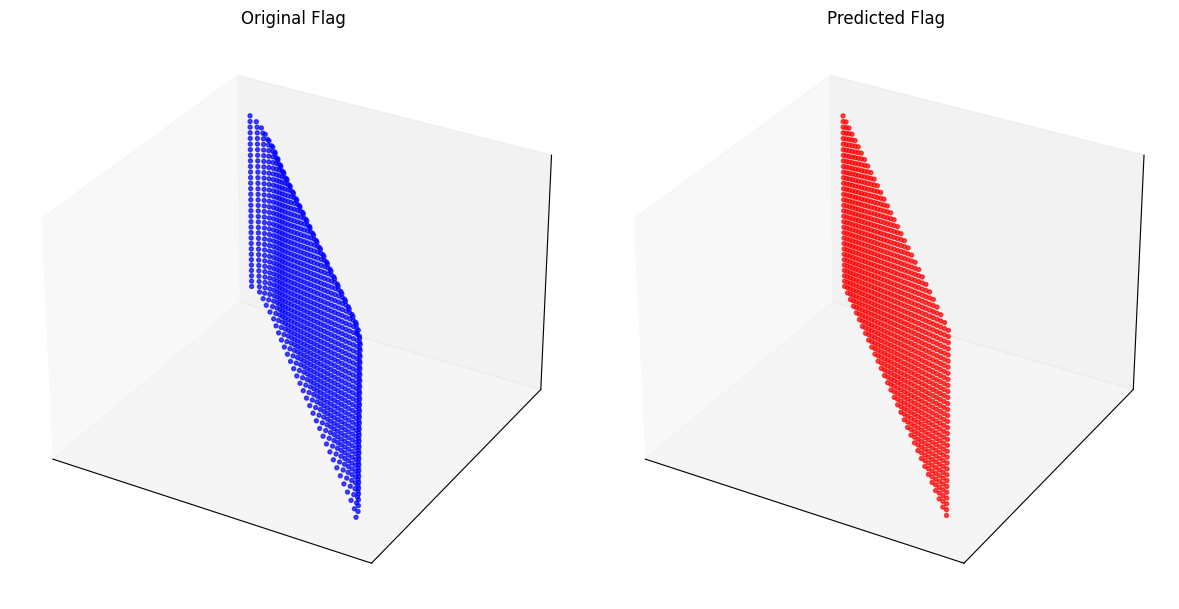

🔹 Visualizing frame 11


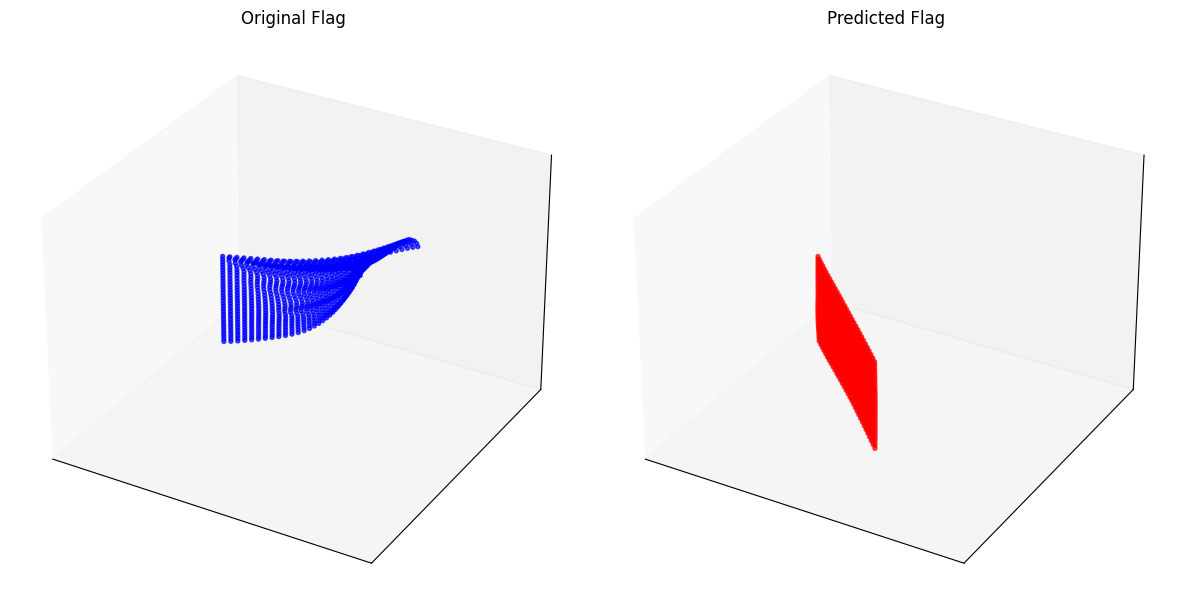

🔹 Visualizing frame 21


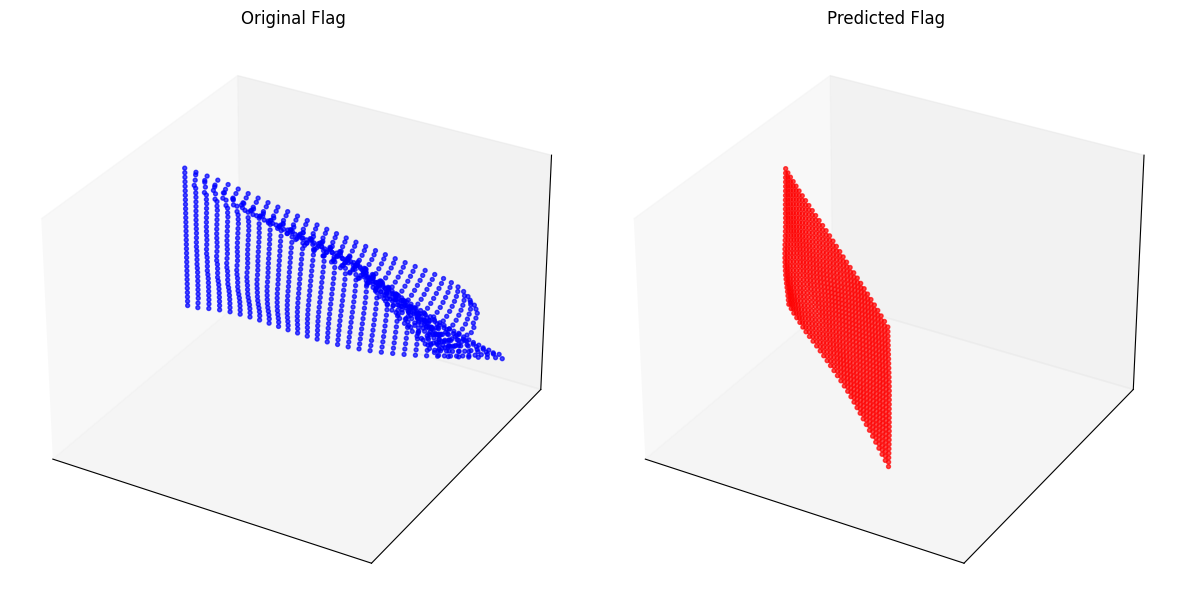

🔹 Visualizing frame 31


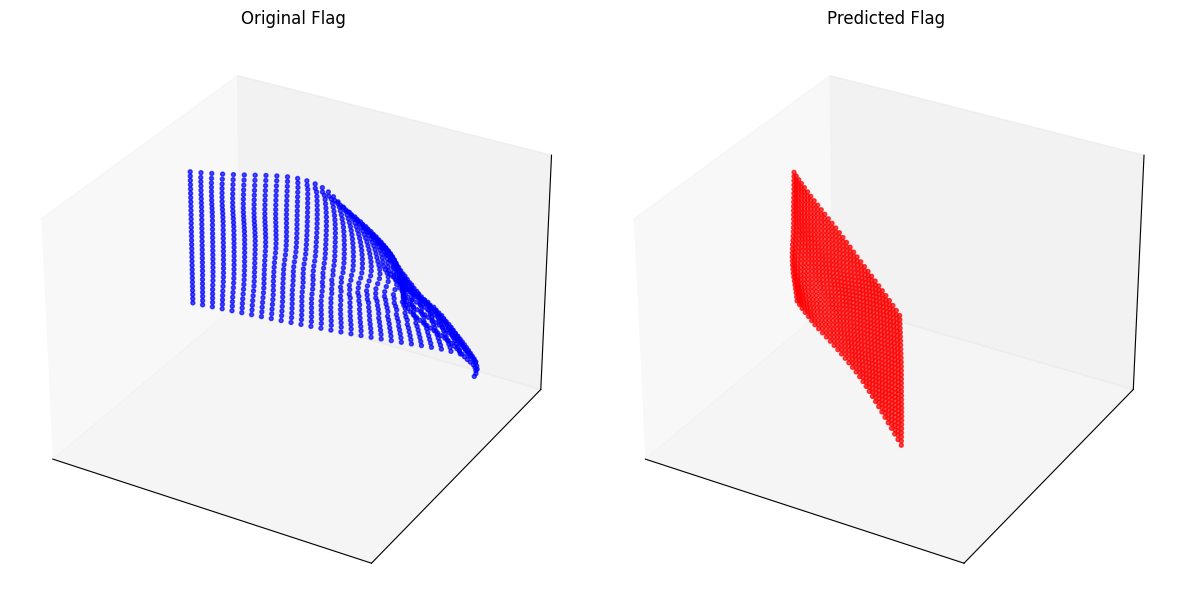

🔹 Visualizing frame 41


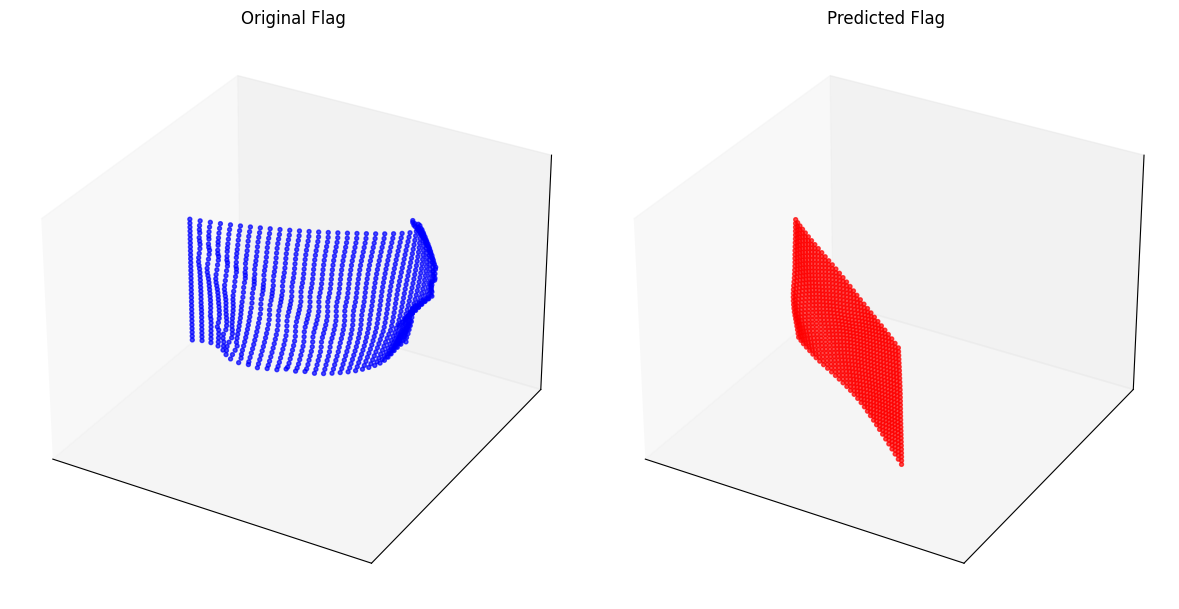

🔹 Visualizing frame 51


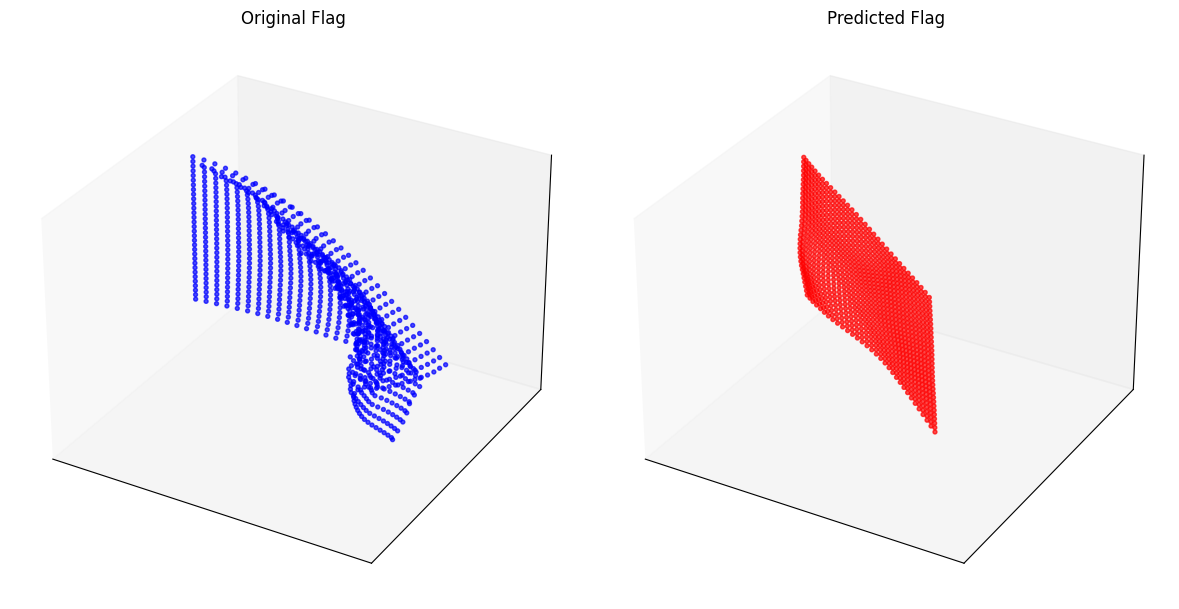

🔹 Visualizing frame 61


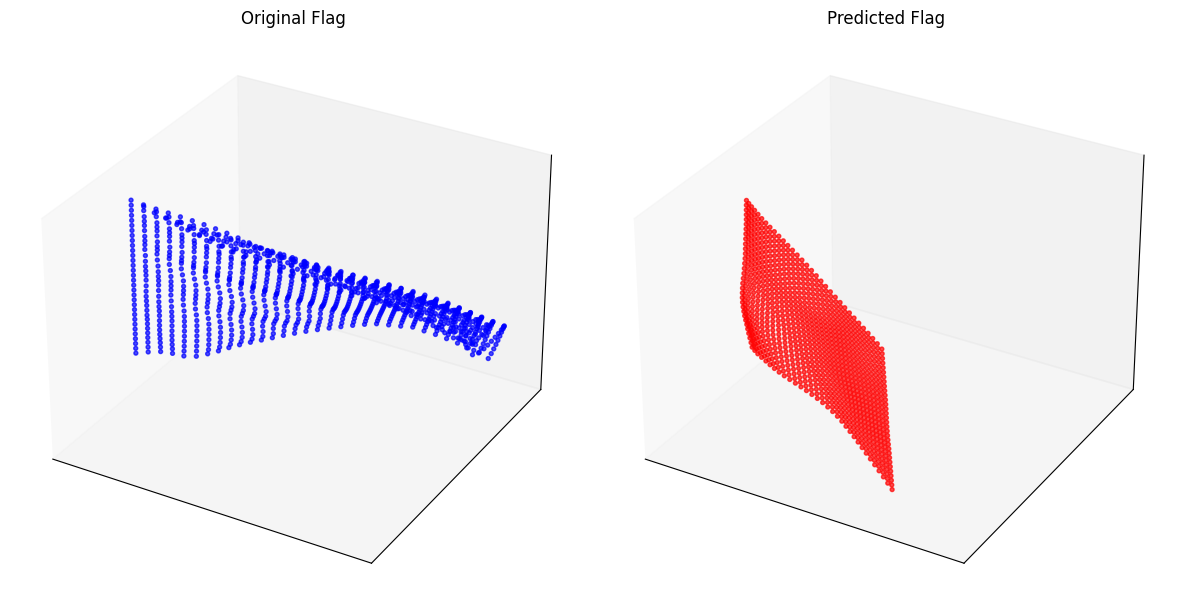

🔹 Visualizing frame 71


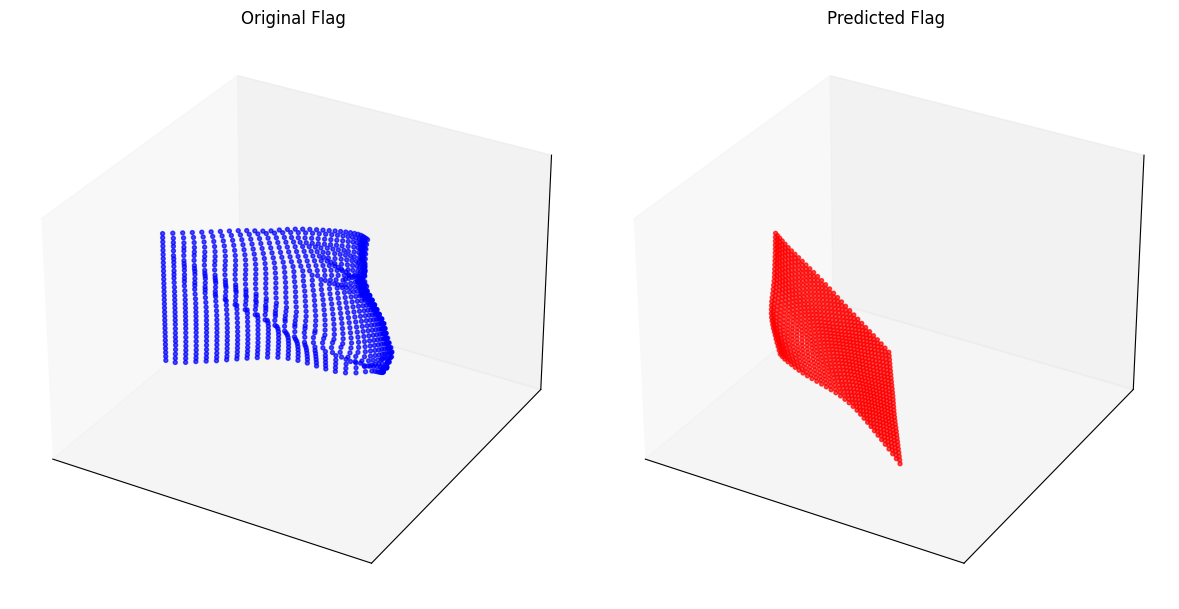

🔹 Visualizing frame 81


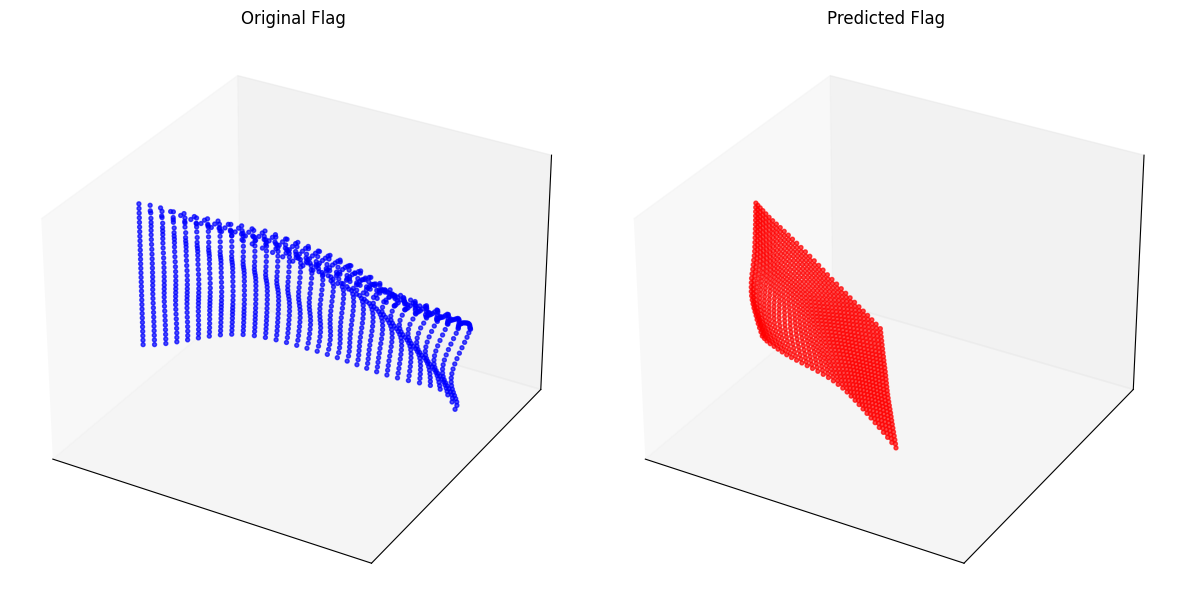

🔹 Visualizing frame 91


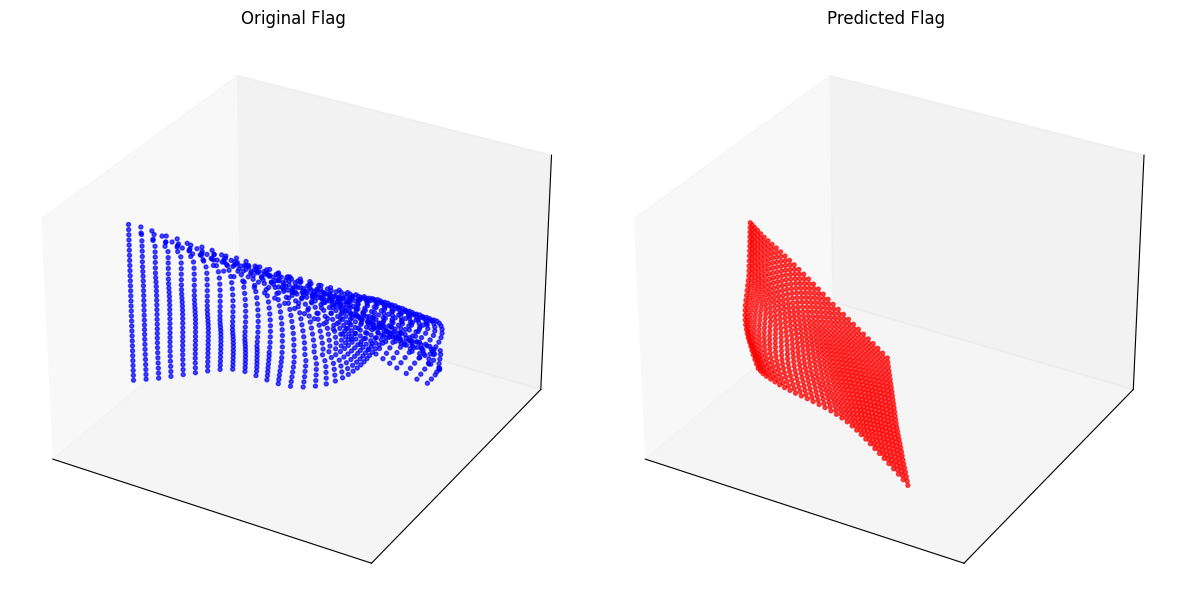

🔹 Visualizing frame 101


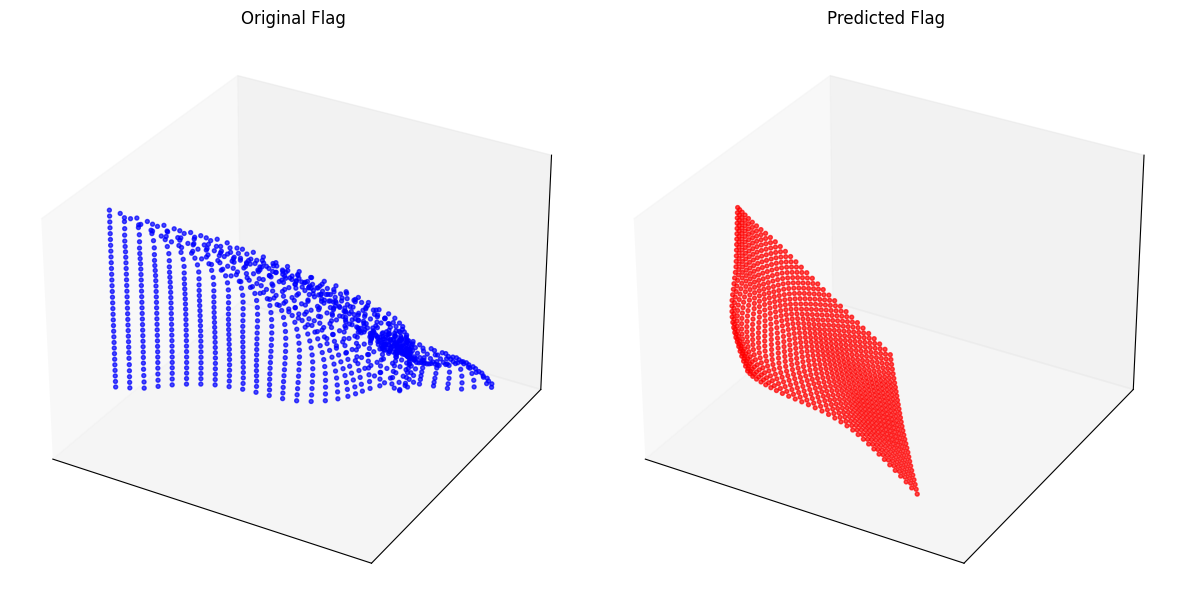

🔹 Visualizing frame 111


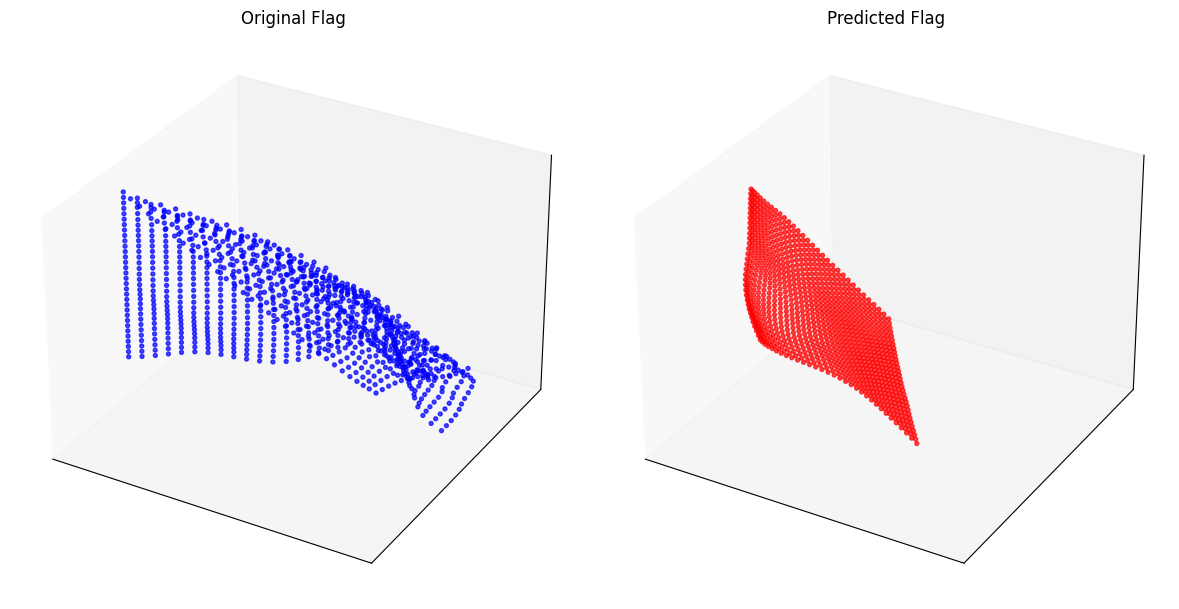

🔹 Visualizing frame 121


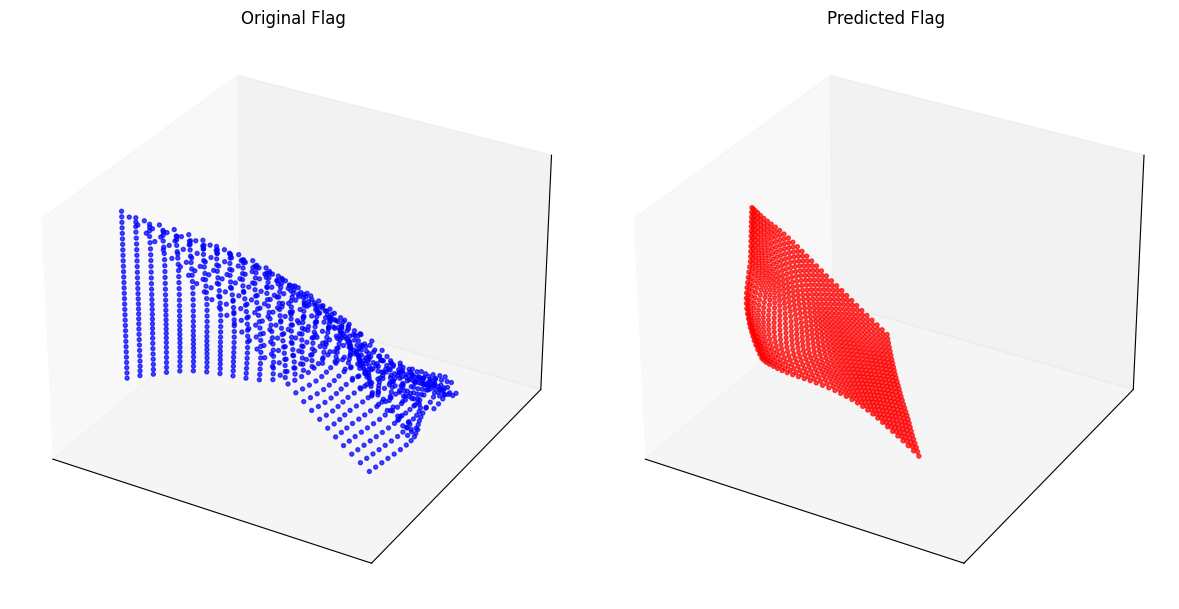

🔹 Visualizing frame 131


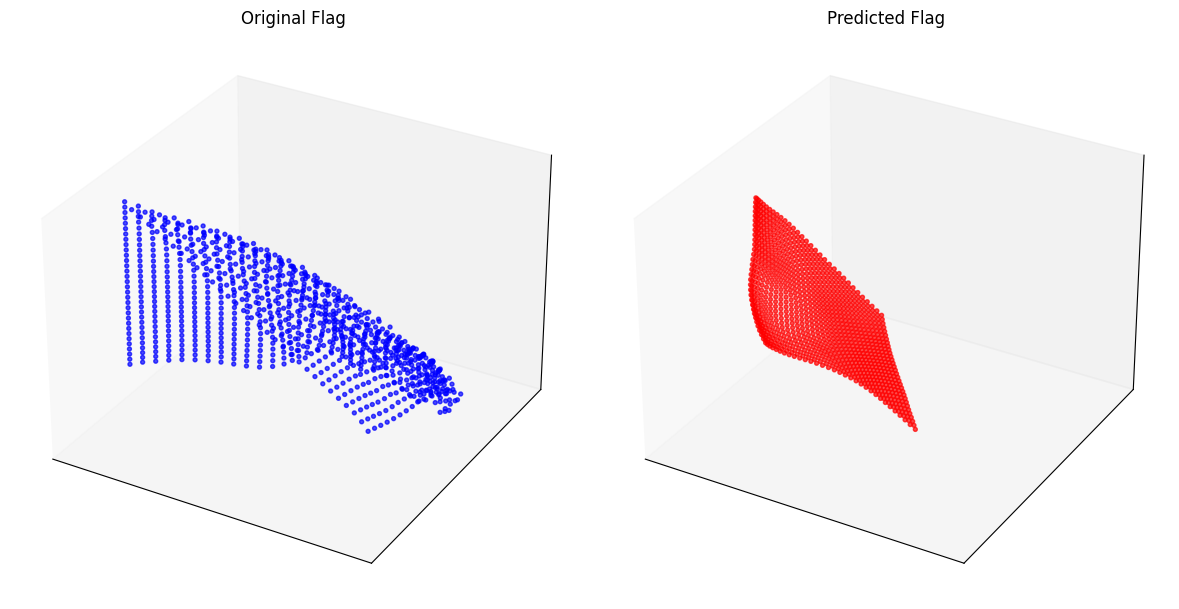

🔹 Visualizing frame 141


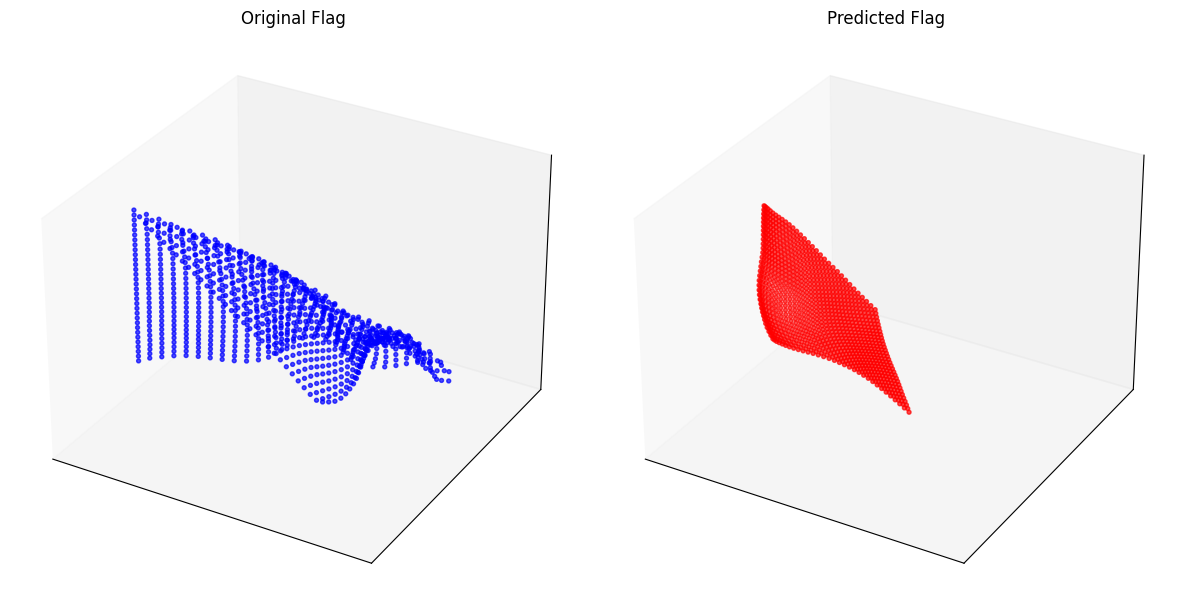

🔹 Visualizing frame 151


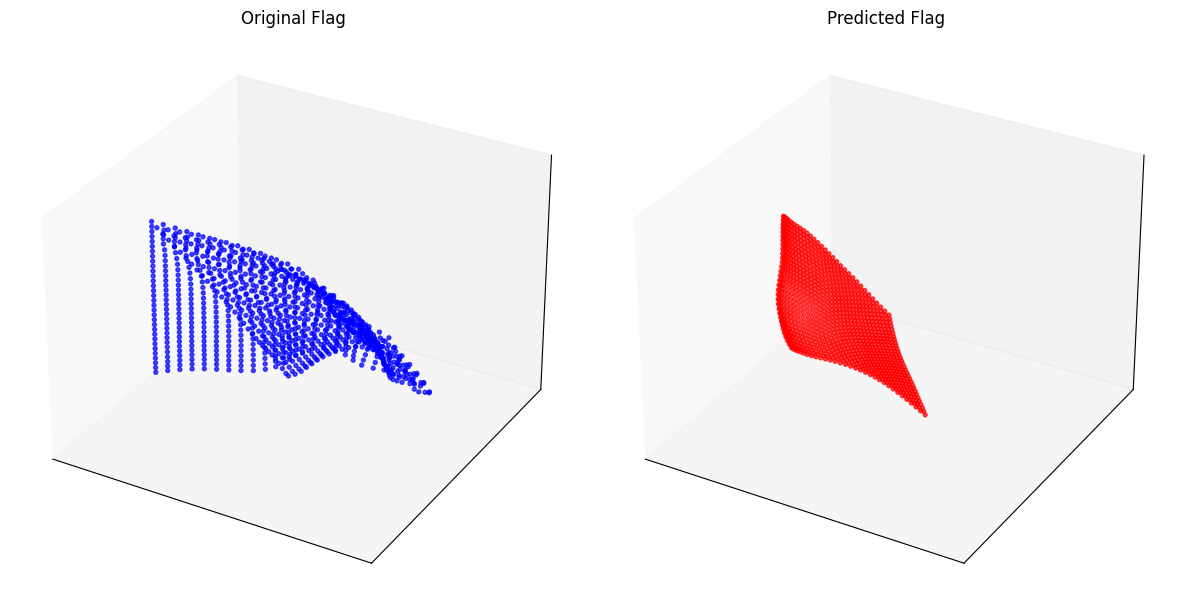

🔹 Visualizing frame 161


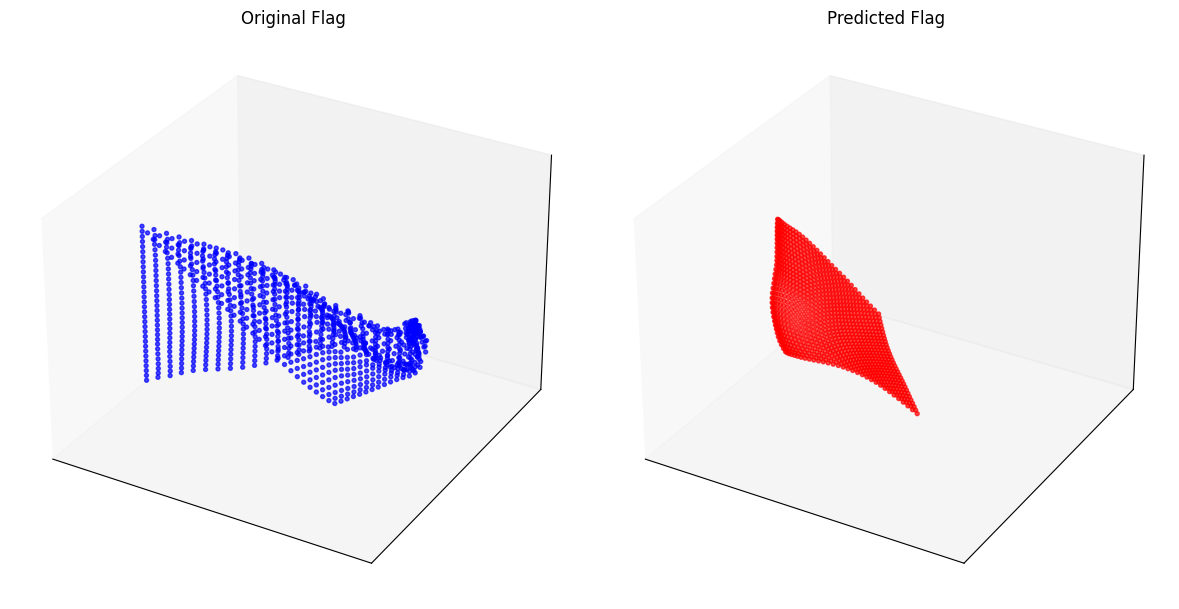

🔹 Visualizing frame 171


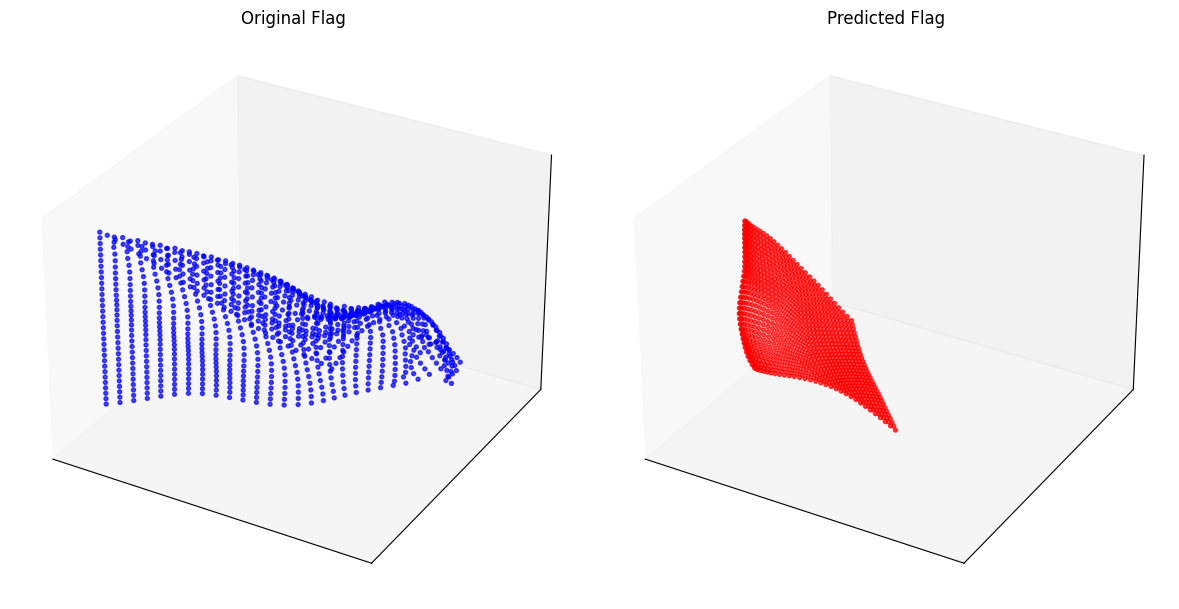

🔹 Visualizing frame 181


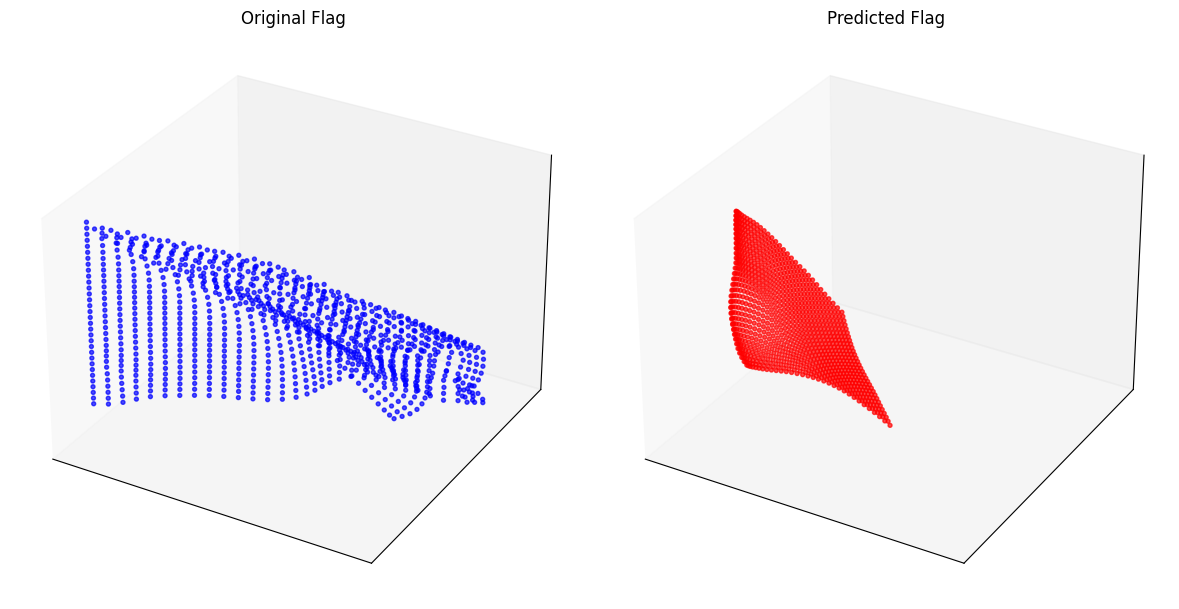

🔹 Visualizing frame 191


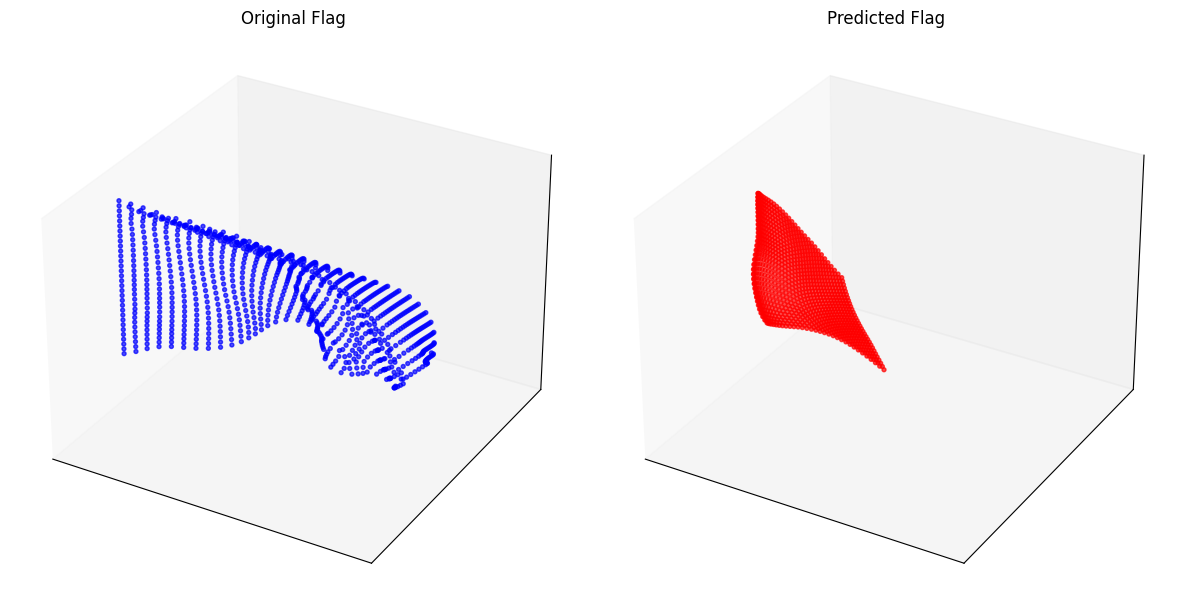

🔹 Visualizing frame 201


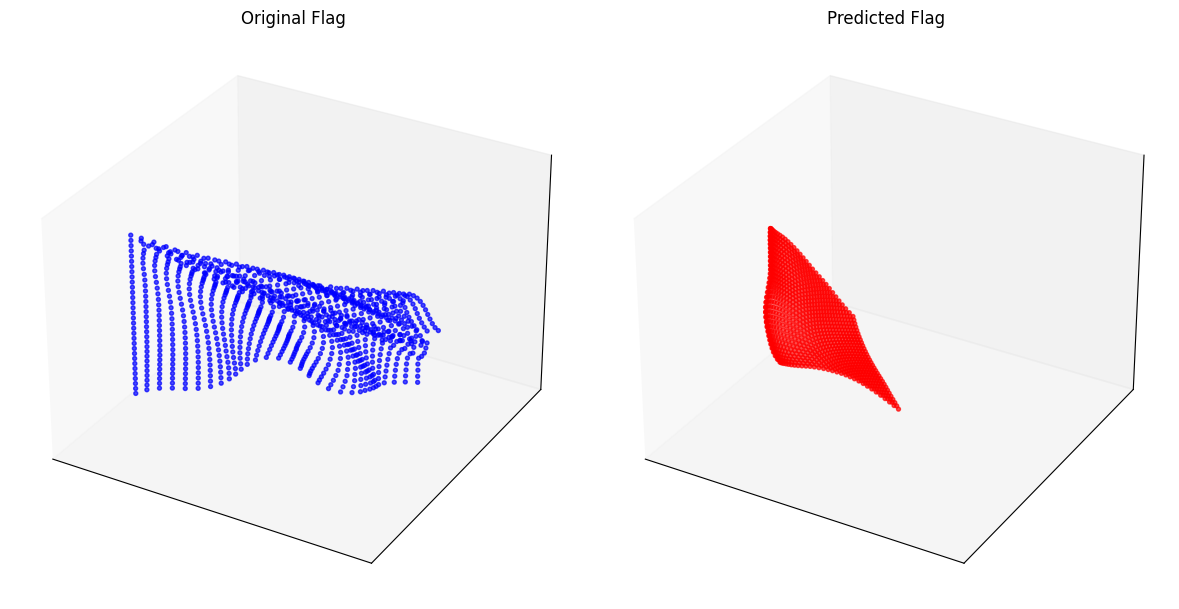

🔹 Visualizing frame 211


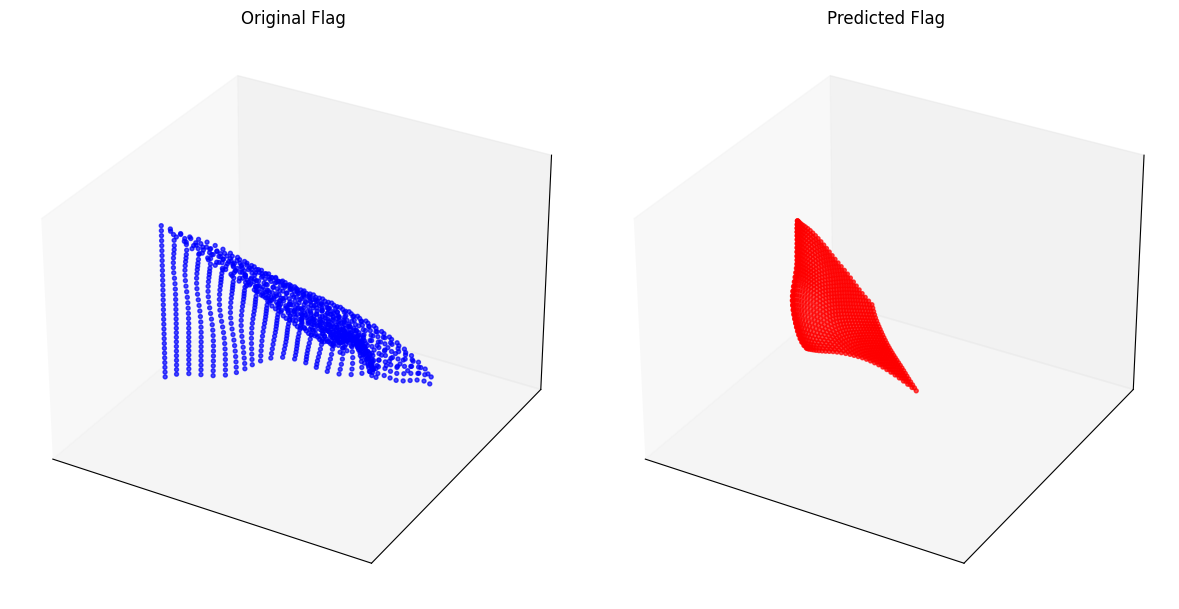

🔹 Visualizing frame 221


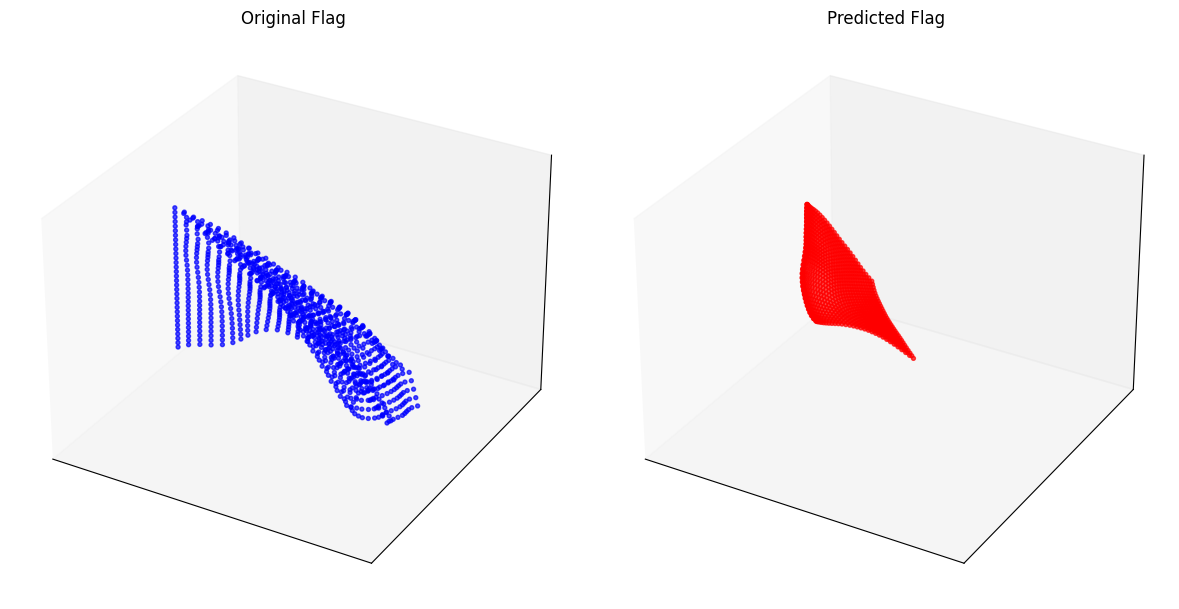

🔹 Visualizing frame 231


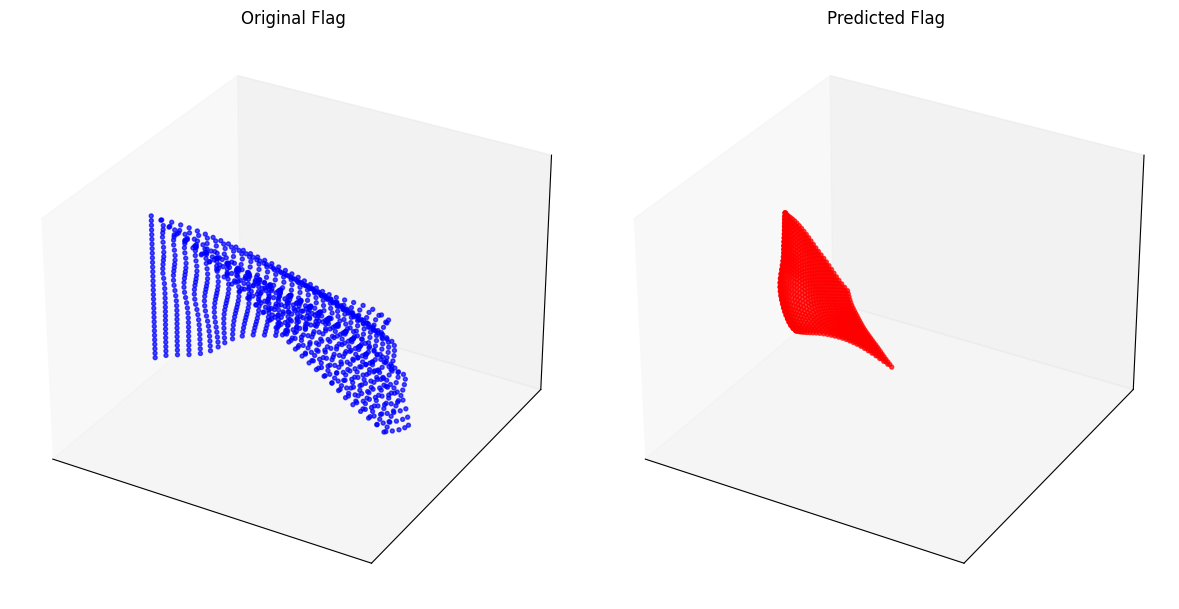

🔹 Visualizing frame 241


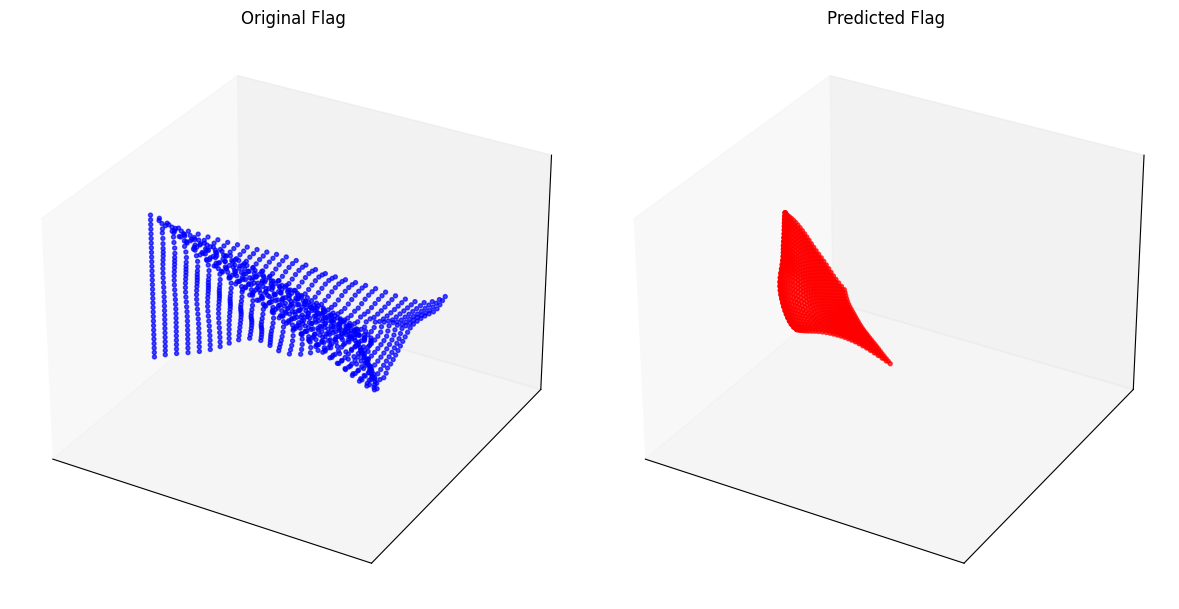

🔹 Visualizing frame 251


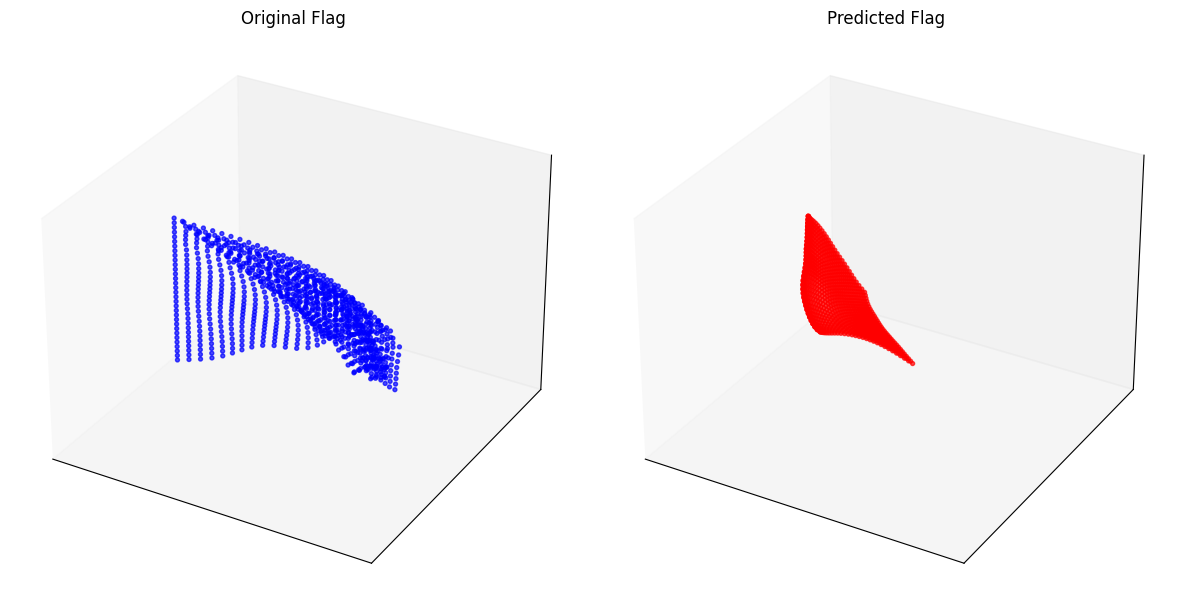

🔹 Visualizing frame 261


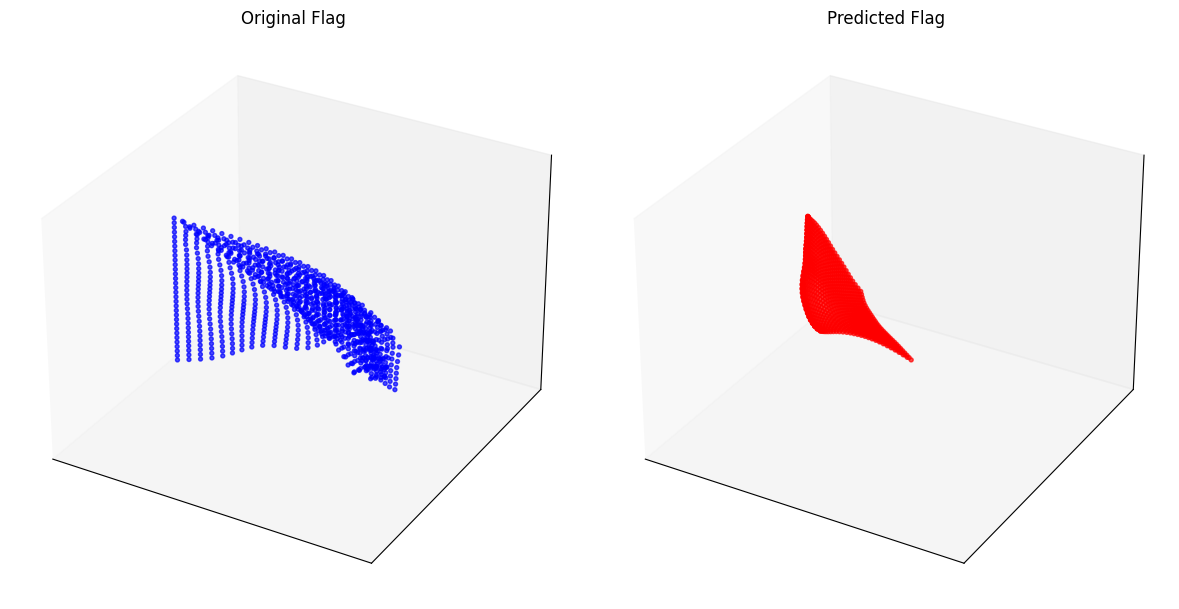

🔹 Visualizing frame 271


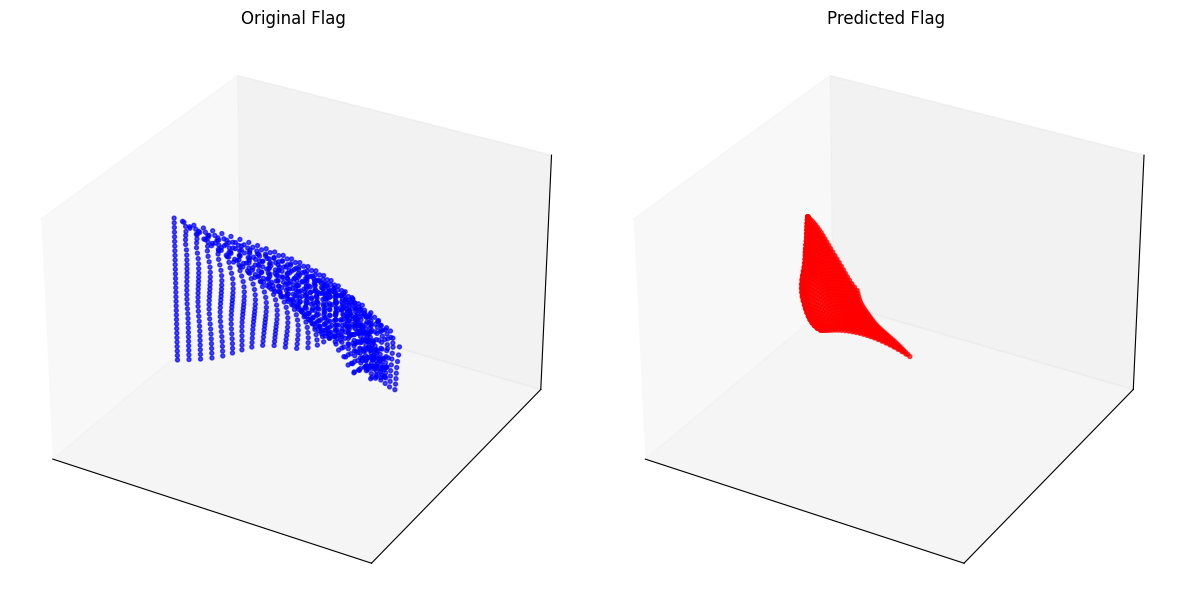

In [36]:
# Example usage
compare_rollout_grid(preds, gts, steps=range(1, 281, 10))